# **Improving Representational Ability in N4-acetylcytidine(AC4C) Dataset using ResVariant**

*Author:Jiawen Li (Spike8086)*


Copyright © [2023] [Jiawen Li]

All rights reserved. This Kaggle Notebook and its contents are the property of [Jiawen Li] and are protected by copyright laws. Unauthorized use, reproduction or distribution of this Notebook or its contents is strictly prohibited. Any infringement of these rights may result in legal action.

# Abstract

**Abstract:The N4-acetylcytidine (AC4C) dataset is a challenging RNA dataset with classes divided into 2 (Negative/Positive) based on participation in mRNA translation. However, the process of AC4C is difficult to observe, and even highly encapsulated ensemble models may not be effective due to the size and cost of training.**

**This paper proposes the use of Seq-to-Seq methods to replace K-mer feature embedding approaches in AC4C to reduce the model size and improve representational ability using a variant of the ResBlock layer. Additionally, the extreme imbalance of the AC4C dataset's sample numbers of each class requires a new formatted criterion to evaluate the model's performance. This research will compare several criteria, including accuracy and R-squared, and explain our methodology.**

In [1]:
import itertools
import numpy as np
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def to_ls(gene):
    return [g for g in gene]

In [3]:
def shuffle(data1,data2):
    mid=list(zip(data1, data2))
    np.random.shuffle(mid)
    return [t[0] for t in mid],[t[1] for t in mid]

def load_AC4C(shffule,log=True):
    train_text=[]
    train_neg=open("/kaggle/input/ac4c-dataset/train_negatives.txt",'r').readlines()
    train_pos=open("/kaggle/input/ac4c-dataset/train_positives.txt",'r').readlines()
    train_text.extend([e[:-1] for e in train_neg])
    train_text.extend([e[:-1] for e in train_pos])
    x_train=[to_ls(d) for d in train_text]
    y_train=[0 for i in range(len(train_neg))]
    y_train.extend([1 for j in range(len(train_pos))])
    
    test_text=[]
    test_neg=open("/kaggle/input/ac4c-dataset/test_negatives.txt",'r').readlines()
    test_pos=open("/kaggle/input/ac4c-dataset/test_positives.txt",'r').readlines()
    test_text.extend([e[:-1] for e in test_neg])
    test_text.extend([e[:-1] for e in test_pos])
    x_test=[to_ls(d) for d in test_text]
    if log:
        print("                   pos      neg")
        print('Train sample num:',len(test_pos),'    ',len(test_neg))
        print('Test sample num: ',len(train_pos),'   ',len(train_neg))
    
    y_test=[0 for i in range(len(train_neg))]
    y_test.extend([1 for j in range(len(train_pos))])
    if shuffle:
        x_train,y_train=shuffle(x_train,y_train)
        x_test,y_test=shuffle(x_test,y_test)
    return x_train,y_train,x_test,y_test

In [4]:
x_train,y_train,x_test,y_test=load_AC4C(True)
np.asarray(x_train).shape

                   pos      neg
Train sample num: 469      4343
Test sample num:  1160     10855


(12015, 415)

# 1. Feature Embedding

**K-mer Embedding**

> K-mer is an ancient RNA processing method that suggest in 2015

        The method is to count all of combination of the possible features.

        It's simple, but it works,notwithstanding the possible burden on embedding size.

In [5]:
def permuteUnique(data,nums):
  return [''.join(x) for x in itertools.product(*[data] * nums)]

def get_features(data):
    return np.unique(data)

def K_mer(data,permute_num):
    result_features=["".join([c for c in p]) for p in permuteUnique(get_features(data),permute_num)]
    return [["".join(d).count(f) for f in result_features] for d in data]

In [6]:
permute_num=2
kmer_embed=np.asarray(K_mer(x_train,permute_num))
print(np.asarray(kmer_embed).shape)

(12015, 25)


In [7]:
kmer_embed[0]

array([29, 22, 32,  0, 28, 36, 21, 10,  0, 25, 31, 24, 17,  0, 24,  0,  0,
        0,  0,  0, 14, 25, 37,  0, 20])

# 2.Construct models

In [8]:
from tensorflow.keras import layers,models,metrics
import tensorflow as tf
from sklearn.metrics import matthews_corrcoef
def mcc(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    true_positives = tf.logical_and(y_true, y_pred)
    true_negatives = tf.logical_and(tf.logical_not(y_true), tf.logical_not(y_pred))
    false_positives = tf.logical_and(y_true, tf.logical_not(y_pred))
    false_negatives = tf.logical_and(tf.logical_not(y_true), y_pred)
    tp = tf.reduce_sum(tf.cast(true_positives, tf.float32))
    tn = tf.reduce_sum(tf.cast(true_negatives, tf.float32))
    fp = tf.reduce_sum(tf.cast(false_positives, tf.float32))
    fn = tf.reduce_sum(tf.cast(false_negatives, tf.float32))
    
    if tp + tn + fp + fn == 0:
        return 0.0
    
    numerator = tp * tn - fp * fn
    denominator = tf.sqrt((tp + fp+ 10e-16) * (tp + fn+ 10e-16) * (tn + fp+ 10e-16) * (tn + fn)+ 10e-16) + 10e-16
    return numerator / denominator


general_metrics=[metrics.BinaryAccuracy(name='ACC'),
                       metrics.SensitivityAtSpecificity(0.5, name='SN'),
                       metrics.SpecificityAtSensitivity(0.5, name='SP'),
                       mcc,
                       metrics.AUC(name='ROC'),
                       metrics.AUC(name='PRC', curve='PR')]

# Hyper Parameters

In [9]:
k=3
layer_num=9
lr=8e-5
EPOCH=10
BATCH_SIZE=128

**Build MLP**

In [10]:
import keras
from keras.metrics import *


input_num=np.asarray(kmer_embed).shape[1]
baseline=models.Sequential([layers.Dense(input_num),
                layers.Dense(128),
                layers.LeakyReLU(0.2),      
                layers.Dense(128),
                layers.LeakyReLU(0.2),
                layers.Dense(128),
                layers.LeakyReLU(0.2),
                 layers.Dense(2, activation='softmax')
                           ])

from keras.optimizers import *

baseline.compile( 
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
his_base=baseline.fit(
    tf.convert_to_tensor(kmer_embed),
    tf.convert_to_tensor(keras.utils.to_categorical(y_train, num_classes=2)),
    epochs=EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 6ms/step - loss: 0.4015 - ACC: 0.8993 - SN: 0.9716 - SP: 0.9716 - mcc: 0.0000e+00 - ROC: 0.9351 - PRC: 0.9186
Epoch 2/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2441 - ACC: 0.9122 - SN: 0.9875 - SP: 0.9875 - mcc: 0.0000e+00 - ROC: 0.9620 - PRC: 0.9569
Epoch 3/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2340 - ACC: 0.9149 - SN: 0.9885 - SP: 0.9885 - mcc: 0.0000e+00 - ROC: 0.9645 - PRC: 0.9607
Epoch 4/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2315 - ACC: 0.9153 - SN: 0.9894 - SP: 0.9894 - mcc: 0.0000e+00 - ROC: 0.9654 - PRC: 0.9624
Epoch 5/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2252 - ACC: 0.9170 - SN: 0.9912 - SP: 0.9912 - mcc: 0.0000e+00 - ROC: 0.9674 - PRC: 0.9656
Epoch 6/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2220 - ACC: 0.9182 - SN: 0.9916 - SP: 0.9916 - mcc: 0.0000e+00 - ROC: 0.9683 - PRC: 0.9669
Epoch 7/10

**Build CNN**

In [11]:
format_size=5
cnn=models.Sequential([layers.Conv1D(2, 2, padding="same",input_shape=(format_size,format_size)),
                layers.Flatten(),
                layers.Dense(128),
                layers.LeakyReLU(0.2),      
                layers.Dense(128),
                layers.LeakyReLU(0.2),
                layers.Dense(128),
                layers.LeakyReLU(0.2),
                layers.Dense(2, activation='softmax')
                           ])
cnn.compile( 
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)

his_cnn=cnn.fit(
    tf.convert_to_tensor(kmer_embed.reshape([len(kmer_embed),format_size,format_size])),
    tf.convert_to_tensor(keras.utils.to_categorical(y_train, num_classes=2)),
    epochs=EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 5ms/step - loss: 0.4801 - ACC: 0.8889 - SN: 0.9690 - SP: 0.9690 - mcc: 0.0000e+00 - ROC: 0.9300 - PRC: 0.9136
Epoch 2/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2714 - ACC: 0.9035 - SN: 0.9833 - SP: 0.9833 - mcc: 0.0000e+00 - ROC: 0.9521 - PRC: 0.9459
Epoch 3/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2622 - ACC: 0.9050 - SN: 0.9854 - SP: 0.9854 - mcc: 0.0000e+00 - ROC: 0.9557 - PRC: 0.9512
Epoch 4/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2570 - ACC: 0.9069 - SN: 0.9869 - SP: 0.9869 - mcc: 0.0000e+00 - ROC: 0.9576 - PRC: 0.9539
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2538 - ACC: 0.9087 - SN: 0.9875 - SP: 0.9875 - mcc: 0.0000e+00 - ROC: 0.9585 - PRC: 0.9552
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2520 - ACC: 0.9077 - SN: 0.9869 - SP: 0.9869 - mcc: 0.0000e+00 - ROC: 0.9592 - PRC: 0.9560
Epoch 7/10

**Build VAE**

In [12]:
encoder=models.Sequential([
                layers.Conv1D(2, 2, padding="same",input_shape=(format_size,format_size)),
                layers.Flatten(),
                layers.Dense(128),
                layers.LeakyReLU(0.2),      
                layers.Dense(format_size**2),
                layers.LeakyReLU(0.2)
                ])
encoder.compile( 
    optimizer = Adam(learning_rate=lr*320),
    loss = 'mse'
)

encoder.fit(
    tf.convert_to_tensor(kmer_embed.reshape([len(kmer_embed),format_size,format_size])),
    tf.convert_to_tensor(kmer_embed),
    epochs=EPOCH*4,
    batch_size=BATCH_SIZE
)

Epoch 1/40
94/94 [==============================] - 1s 2ms/step - loss: 22.9144
Epoch 2/40
94/94 [==============================] - 0s 2ms/step - loss: 5.2786
Epoch 3/40
94/94 [==============================] - 0s 2ms/step - loss: 4.6780
Epoch 4/40
94/94 [==============================] - 0s 2ms/step - loss: 4.3824
Epoch 5/40
94/94 [==============================] - 0s 2ms/step - loss: 4.1206
Epoch 6/40
94/94 [==============================] - 0s 2ms/step - loss: 4.1074
Epoch 7/40
94/94 [==============================] - 0s 2ms/step - loss: 4.0039
Epoch 8/40
94/94 [==============================] - 0s 2ms/step - loss: 4.0452
Epoch 9/40
94/94 [==============================] - 0s 2ms/step - loss: 3.9446
Epoch 10/40
94/94 [==============================] - 0s 3ms/step - loss: 3.9699
Epoch 11/40
94/94 [==============================] - 0s 2ms/step - loss: 3.8793
Epoch 12/40
94/94 [==============================] - 0s 3ms/step - loss: 3.7742
Epoch 13/40
94/94 [=============================

In [13]:
from keras.models import Model
mid_result=[l.output for l in encoder.layers]
encoder_final=Model(inputs=encoder.input, outputs=mid_result[-2])
mid_data=encoder_final(kmer_embed.reshape([len(kmer_embed),format_size,format_size]))
decoder=models.Sequential([
                layers.Dense(mid_data.shape[1]),
                layers.LeakyReLU(0.2),
                layers.Dense(128),
                layers.LeakyReLU(0.2),
                layers.Dense(2, activation='softmax')
                ])
decoder.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
decoder.fit(mid_data,
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 3ms/step - loss: 0.7149 - ACC: 0.8695 - SN: 0.9574 - SP: 0.9574 - mcc: 0.0000e+00 - ROC: 0.9098 - PRC: 0.8852
Epoch 2/10
94/94 [==============================] - 0s 3ms/step - loss: 0.3321 - ACC: 0.8877 - SN: 0.9773 - SP: 0.9773 - mcc: 0.0000e+00 - ROC: 0.9389 - PRC: 0.9313
Epoch 3/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2823 - ACC: 0.9047 - SN: 0.9824 - SP: 0.9824 - mcc: 0.0000e+00 - ROC: 0.9519 - PRC: 0.9451
Epoch 4/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2678 - ACC: 0.9076 - SN: 0.9846 - SP: 0.9846 - mcc: 0.0000e+00 - ROC: 0.9551 - PRC: 0.9486
Epoch 5/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2598 - ACC: 0.9084 - SN: 0.9851 - SP: 0.9851 - mcc: 0.0000e+00 - ROC: 0.9572 - PRC: 0.9519
Epoch 6/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2528 - ACC: 0.9112 - SN: 0.9867 - SP: 0.9867 - mcc: 0.0000e+00 - ROC: 0.9589 - PRC: 0.9539
Epoch 7/10

In [14]:
vae=models.Sequential([encoder_final,decoder])
vae.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)

his_vae=vae.fit(
    tf.convert_to_tensor(kmer_embed.reshape([len(kmer_embed),format_size,format_size])),
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)


Epoch 1/10
94/94 [==============================] - 2s 3ms/step - loss: 0.2389 - ACC: 0.9130 - SN: 0.9883 - SP: 0.9883 - mcc: 0.0000e+00 - ROC: 0.9630 - PRC: 0.9601
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2371 - ACC: 0.9138 - SN: 0.9894 - SP: 0.9894 - mcc: 0.0000e+00 - ROC: 0.9638 - PRC: 0.9614
Epoch 3/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2318 - ACC: 0.9152 - SN: 0.9898 - SP: 0.9898 - mcc: 0.0000e+00 - ROC: 0.9654 - PRC: 0.9633
Epoch 4/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2301 - ACC: 0.9148 - SN: 0.9900 - SP: 0.9900 - mcc: 0.0000e+00 - ROC: 0.9661 - PRC: 0.9642
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2279 - ACC: 0.9159 - SN: 0.9908 - SP: 0.9908 - mcc: 0.0000e+00 - ROC: 0.9668 - PRC: 0.9651
Epoch 6/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2281 - ACC: 0.9166 - SN: 0.9911 - SP: 0.9911 - mcc: 0.0000e+00 - ROC: 0.9667 - PRC: 0.9647
Epoch 7/10

**Build AE with ResBlock**

In [15]:
class ResBlockVar(layers.Layer):
    def __init__(self,layer_num,units,res_stride,var=True):
        super().__init__()
        self.var=var
        self.layers=[layers.Dense(units,activation=layers.LeakyReLU(0.2)) for i in range(layer_num)]
        self.res_stride=res_stride
    def call(self,x):
        x_lis=[]
        for i in range(len(self.layers)-self.res_stride):
            if self.var:
                x=self.layers[i](x)+self.layers[i+self.res_stride](x)
            if not self.var:
                if (i+1)%k==0:
                    x=self.layers[i](x)+self.layers[i+self.res_stride](x)
                else:
                    x=self.layers[i](x)
        return x

In [16]:
decoder_vae=models.Sequential([
                ResBlockVar(layer_num,mid_data.shape[1],k,False),
                layers.Flatten(),
                layers.Dense(2, activation='softmax')
                ])
decoder_vae.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
decoder_vae.fit(mid_data,
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 3s 4ms/step - loss: 0.3634 - ACC: 0.8953 - SN: 0.9804 - SP: 0.9804 - mcc: 0.0000e+00 - ROC: 0.9468 - PRC: 0.9405
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2894 - ACC: 0.9070 - SN: 0.9781 - SP: 0.9781 - mcc: 0.0000e+00 - ROC: 0.9462 - PRC: 0.9386
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2663 - ACC: 0.9094 - SN: 0.9828 - SP: 0.9828 - mcc: 0.0000e+00 - ROC: 0.9534 - PRC: 0.9482
Epoch 4/10
94/94 [==============================] - 0s 3ms/step - loss: 0.2544 - ACC: 0.9133 - SN: 0.9851 - SP: 0.9851 - mcc: 0.0000e+00 - ROC: 0.9572 - PRC: 0.9525
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2472 - ACC: 0.9132 - SN: 0.9879 - SP: 0.9879 - mcc: 0.0000e+00 - ROC: 0.9600 - PRC: 0.9561
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2439 - ACC: 0.9141 - SN: 0.9864 - SP: 0.9864 - mcc: 0.0000e+00 - ROC: 0.9611 - PRC: 0.9579
Epoch 7/10

In [17]:
vae_res=models.Sequential([encoder_final,decoder_vae])
vae_res.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
his_res=vae_res.fit(
    tf.convert_to_tensor(kmer_embed.reshape([len(kmer_embed),format_size,format_size])),
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 4ms/step - loss: 0.2316 - ACC: 0.9155 - SN: 0.9898 - SP: 0.9898 - mcc: 0.0000e+00 - ROC: 0.9652 - PRC: 0.9629
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2270 - ACC: 0.9154 - SN: 0.9904 - SP: 0.9904 - mcc: 0.0000e+00 - ROC: 0.9669 - PRC: 0.9652
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2247 - ACC: 0.9168 - SN: 0.9910 - SP: 0.9910 - mcc: 0.0000e+00 - ROC: 0.9677 - PRC: 0.9662
Epoch 4/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2230 - ACC: 0.9177 - SN: 0.9916 - SP: 0.9916 - mcc: 0.0000e+00 - ROC: 0.9683 - PRC: 0.9669
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2214 - ACC: 0.9164 - SN: 0.9925 - SP: 0.9925 - mcc: 0.0000e+00 - ROC: 0.9688 - PRC: 0.9675
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2209 - ACC: 0.9164 - SN: 0.9914 - SP: 0.9914 - mcc: 0.0000e+00 - ROC: 0.9690 - PRC: 0.9676
Epoch 7/10

**Build AE with ResVariant**

In [18]:
decoder_var=models.Sequential([
                ResBlockVar(layer_num,mid_data.shape[1],k),
                layers.Flatten(),
                layers.Dense(2, activation='softmax')
                ])
decoder_var.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
decoder_var.fit(mid_data,
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 4ms/step - loss: 1.3265 - ACC: 0.8866 - SN: 0.9607 - SP: 0.9607 - mcc: 0.0000e+00 - ROC: 0.9196 - PRC: 0.8966
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 0.3664 - ACC: 0.8859 - SN: 0.9813 - SP: 0.9813 - mcc: 0.0000e+00 - ROC: 0.9426 - PRC: 0.9353
Epoch 3/10
94/94 [==============================] - 0s 3ms/step - loss: 0.3173 - ACC: 0.8961 - SN: 0.9811 - SP: 0.9811 - mcc: 0.0000e+00 - ROC: 0.9484 - PRC: 0.9429
Epoch 4/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2900 - ACC: 0.9020 - SN: 0.9825 - SP: 0.9825 - mcc: 0.0000e+00 - ROC: 0.9529 - PRC: 0.9485
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2796 - ACC: 0.9042 - SN: 0.9834 - SP: 0.9834 - mcc: 0.0000e+00 - ROC: 0.9544 - PRC: 0.9497
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2744 - ACC: 0.9054 - SN: 0.9832 - SP: 0.9832 - mcc: 0.0000e+00 - ROC: 0.9550 - PRC: 0.9507
Epoch 7/10

In [19]:
vae_var=models.Sequential([encoder_final,decoder_var])
vae_var.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'categorical_crossentropy',
    metrics=general_metrics
)
his_var=vae_var.fit(
    tf.convert_to_tensor(kmer_embed.reshape([len(kmer_embed),format_size,format_size])),
            keras.utils.to_categorical(y_train,num_classes=2),
            epochs=EPOCH,
            batch_size=BATCH_SIZE
)

Epoch 1/10
94/94 [==============================] - 2s 5ms/step - loss: 0.2546 - ACC: 0.9093 - SN: 0.9869 - SP: 0.9869 - mcc: 0.0000e+00 - ROC: 0.9590 - PRC: 0.9550
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2447 - ACC: 0.9125 - SN: 0.9868 - SP: 0.9868 - mcc: 0.0000e+00 - ROC: 0.9620 - PRC: 0.9584
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2424 - ACC: 0.9131 - SN: 0.9891 - SP: 0.9891 - mcc: 0.0000e+00 - ROC: 0.9627 - PRC: 0.9592
Epoch 4/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2400 - ACC: 0.9136 - SN: 0.9894 - SP: 0.9894 - mcc: 0.0000e+00 - ROC: 0.9634 - PRC: 0.9599
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2366 - ACC: 0.9143 - SN: 0.9888 - SP: 0.9888 - mcc: 0.0000e+00 - ROC: 0.9643 - PRC: 0.9614
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 0.2351 - ACC: 0.9142 - SN: 0.9888 - SP: 0.9888 - mcc: 0.0000e+00 - ROC: 0.9644 - PRC: 0.9612
Epoch 7/10

# 3.Evaluate the models

In [20]:
x_test_1d=tf.convert_to_tensor(np.asarray(K_mer(x_test,permute_num)))
x_test_2d=tf.convert_to_tensor(np.asarray(K_mer(x_test,permute_num)).reshape([len(x_test),format_size,format_size]))
y_test=tf.convert_to_tensor(keras.utils.to_categorical(y_test,num_classes=2))

In [21]:
base_score=baseline.evaluate(
                x_test_1d,y_test
              )
cnn_score=cnn.evaluate(
                x_test_2d,y_test
              )
vae_score=vae.evaluate(
                x_test_2d,y_test
                )
res_score=vae_res.evaluate(
               x_test_2d,y_test
              )
var_score=vae_var.evaluate(
     x_test_2d,y_test
)

151/151 [==============================] - 1s 3ms/step - loss: 0.1176 - ACC: 0.9661 - SN: 1.0000 - SP: 1.0000 - mcc: 0.0000e+00 - ROC: 0.9946 - PRC: 0.9948


**Ablation Experiment**

As we except $\sqrt{mn(L+e_{ResVariant})\mu^2} >\sqrt{mn(L+e_{ResBlock})\mu^2}$.

$\left \|W_{ResVaraint}\right \| _{F}>\left \|W_{ResBlock}\right \| _{F}$

Which means ResVariant have stronger representaional ability.

In [22]:
import pandas as pd

base_score.append(baseline.count_params())
cnn_score.append(cnn.count_params())
vae_score.append(vae.count_params())
res_score.append(vae_res.count_params())
var_score.append(vae_var.count_params())
scores=[base_score[1:],cnn_score[1:],vae_score[1:],res_score[1:],var_score[1:]]
criterion_names=['ACC','SP','SN',"MCC",'ROC','PRC',"parameters"]
model_names=['MLP_standard','CNN_standard','AE_standsard','AE_ResBlock','AE_ResVar']

result=pd.DataFrame(data=scores,index=model_names).rename_axis("Model\Criterion",axis=1)
result.rename(columns={origin:new for origin,new in zip(range(len(criterion_names)),criterion_names)})

Model\Criterion,ACC,SP,SN,MCC,ROC,PRC,parameters
MLP_standard,0.945137,0.999584,0.999584,0.0,0.988768,0.989020,37260
CNN_standard,0.966334,0.997091,0.997091,0.0,0.991814,0.991249,34712
AE_standsard,0.936825,0.997091,0.997091,0.0,0.982799,0.982006,8891
AE_ResBlock,0.932253,0.998338,0.998338,0.0,0.983186,0.983504,9257
AE_ResVar,0.966126,1.000000,1.000000,0.0,0.994614,0.994757,10557


**The accuracy during training**

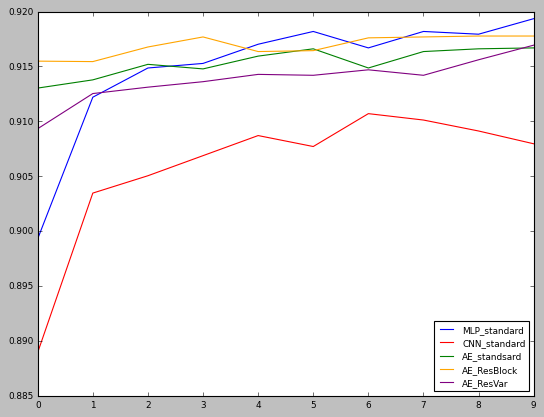

In [23]:
import matplotlib.pyplot as plt
#use IEEE style
plt.style.use('classic')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Computer Modern Roman'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 5,
    'axes.prop_cycle': plt.cycler(color=['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']),
})

crteira_name='ACC'
plt.plot(his_base.history[crteira_name])
plt.plot(his_cnn.history[crteira_name])
plt.plot(his_vae.history[crteira_name])
plt.plot(his_res.history[crteira_name])
plt.plot(his_var.history[crteira_name])
plt.legend(model_names,loc='lower right')
plt.savefig("image.png")
plt.show()

In [24]:
baseline.save('mlp_standard.h5')
cnn.save('cnn_standard.h5')
vae.save('vae_standard.h5')
vae_res.save('vae_res.h5')
vae_var.save('vae_var.h5')

In [25]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 2)              22        
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               1408      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 25)                3225      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 25)                0         
                                                                 
Total params: 4,655
Trainable params: 4,655
Non-traina

In [26]:
decoder_var.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block_var_1 (ResBlockVa  (None, 25)               5850      
 r)                                                              
                                                                 
 flatten_3 (Flatten)         (None, 25)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 52        
                                                                 
Total params: 5,902
Trainable params: 5,902
Non-trainable params: 0
_________________________________________________________________


# Encoding Visualization

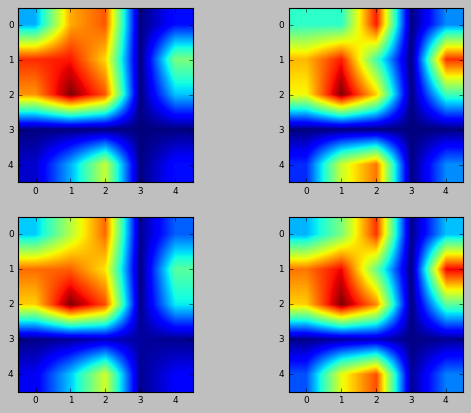

In [27]:
bias=30
for i in range(2):
    test_sample=np.asarray(x_test_2d[i+bias])
    plt.subplot(2,2,i+1)
    plt.imshow(test_sample)
    plt.subplot(2,2,i+3)
    plt.imshow(np.asarray(encoder_final(tf.convert_to_tensor(test_sample.reshape(1,5,5)))).reshape(5,5))
plt.savefig("edge_reinforce")